In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## L02 - Linear and Logistic regression

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'boston_housing'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [4]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [5]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [6]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## DataSet

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, moduleDir, 'boston_house_price.csv'))

data_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [10]:
for col in data_df.columns:
    print (f'Column- {col} : {data_df[col].unique()}')

Column- CRIM : [6.32000e-03 2.73100e-02 2.72900e-02 3.23700e-02 6.90500e-02 2.98500e-02
 8.82900e-02 1.44550e-01 2.11240e-01 1.70040e-01 2.24890e-01 1.17470e-01
 9.37800e-02 6.29760e-01 6.37960e-01 6.27390e-01 1.05393e+00 7.84200e-01
 8.02710e-01 7.25800e-01 1.25179e+00 8.52040e-01 1.23247e+00 9.88430e-01
 7.50260e-01 8.40540e-01 6.71910e-01 9.55770e-01 7.72990e-01 1.00245e+00
 1.13081e+00 1.35472e+00 1.38799e+00 1.15172e+00 1.61282e+00 6.41700e-02
 9.74400e-02 8.01400e-02 1.75050e-01 2.76300e-02 3.35900e-02 1.27440e-01
 1.41500e-01 1.59360e-01 1.22690e-01 1.71420e-01 1.88360e-01 2.29270e-01
 2.53870e-01 2.19770e-01 8.87300e-02 4.33700e-02 5.36000e-02 4.98100e-02
 1.36000e-02 1.31100e-02 2.05500e-02 1.43200e-02 1.54450e-01 1.03280e-01
 1.49320e-01 1.71710e-01 1.10270e-01 1.26500e-01 1.95100e-02 3.58400e-02
 4.37900e-02 5.78900e-02 1.35540e-01 1.28160e-01 8.82600e-02 1.58760e-01
 9.16400e-02 1.95390e-01 7.89600e-02 9.51200e-02 1.01530e-01 8.70700e-02
 5.64600e-02 8.38700e-02 4.11300e-02

In [11]:
data_df.shape

(506, 14)

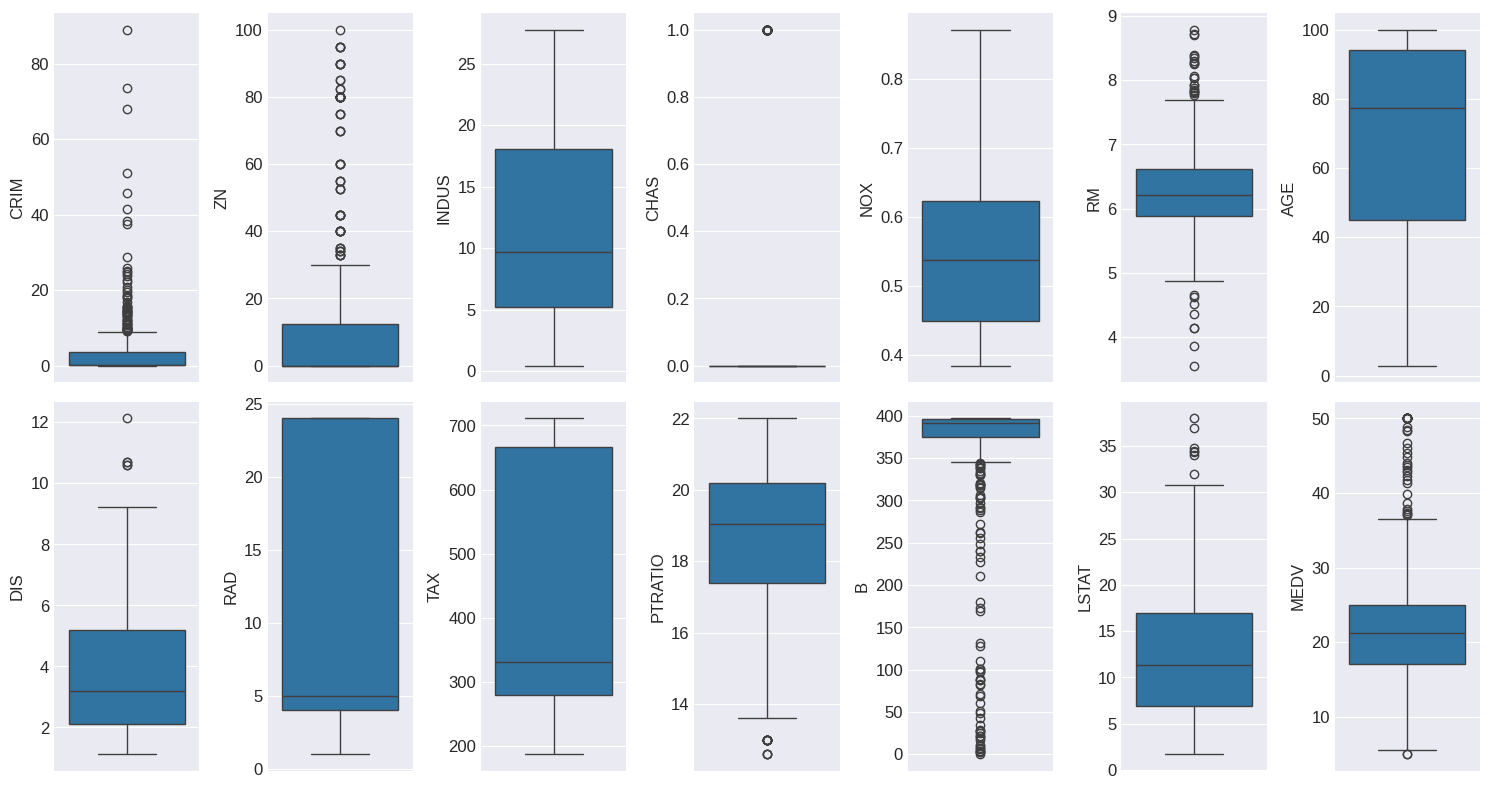

In [12]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(15, 8)) # instantiate a figure

axes = axes.flatten() # flatten all axes

for count, col in enumerate(data_df.columns):
    ax = axes[count]
    
    sns.boxplot(y=col, data=data_df, ax=ax) # box plot of the columns

 
plt.tight_layout();


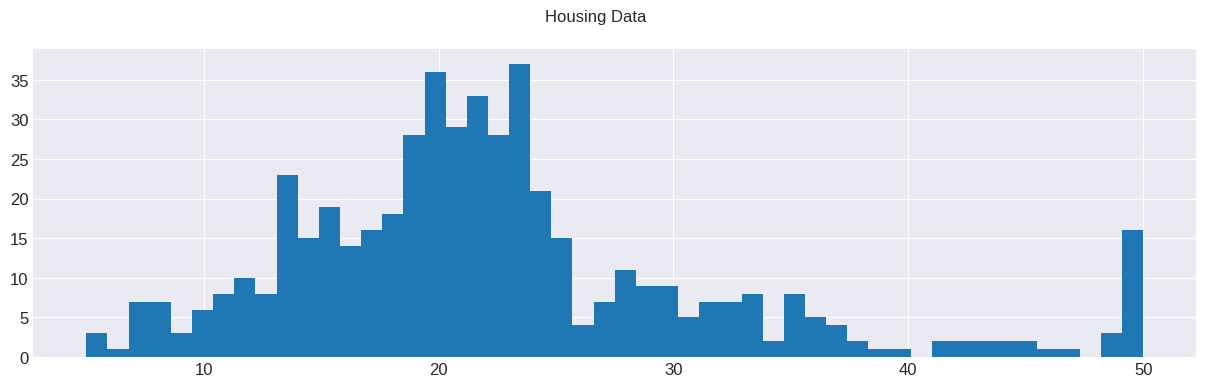

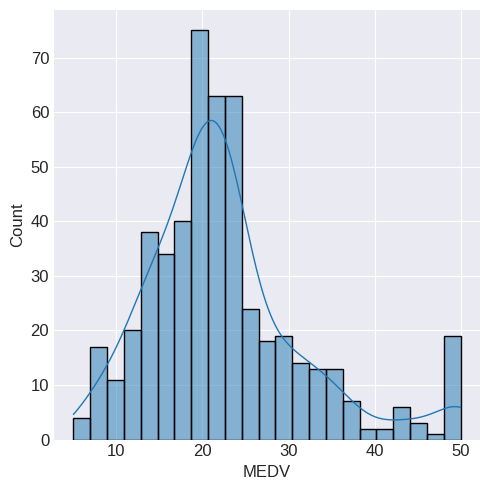

In [13]:
# Plot the features
fig = plt.figure( figsize = (15 , 4) ) 
fig.suptitle('Housing Data')
ax = fig.add_subplot()                
n, bins, patches = ax.hist( data_df['MEDV'], 50)
ax.axis('tight')              
sns.displot(data = data_df, x ='MEDV', kde=True)
plt.tight_layout()

plt.show()

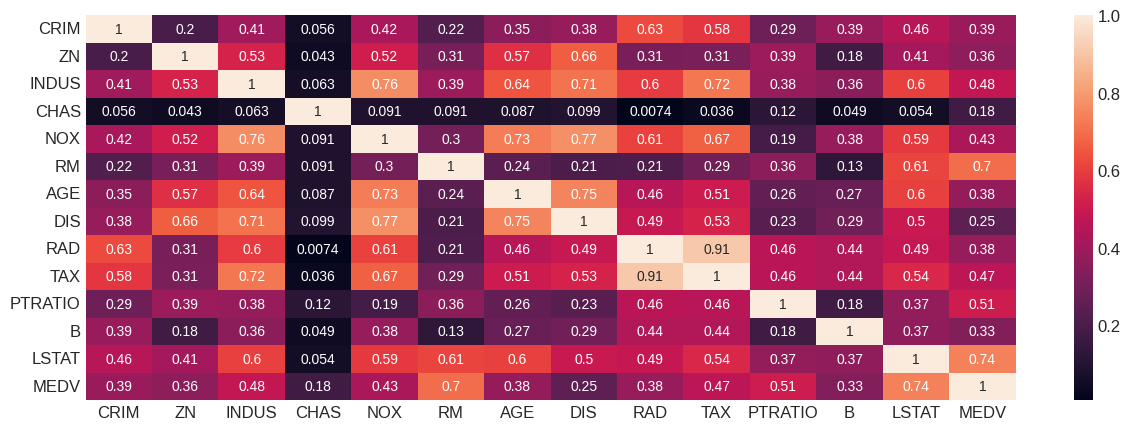

In [14]:
sns.heatmap(data_df.corr().abs(),  annot=True);

In [15]:
data_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [16]:
rel_col =['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV'] # pick relevant columns

data_df = data_df[rel_col].copy() # make a copy
data_df.head()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,MEDV
0,2.31,0.538,6.575,296.0,15.3,4.98,24.0
1,7.07,0.469,6.421,242.0,17.8,9.14,21.6
2,7.07,0.469,7.185,242.0,17.8,4.03,34.7
3,2.18,0.458,6.998,222.0,18.7,2.94,33.4
4,2.18,0.458,7.147,222.0,18.7,5.33,36.2


In [17]:
data_df.shape

(506, 7)

In [18]:
data_df = data_df[data_df['MEDV']<50].copy()

In [19]:
data_df.shape

(490, 7)

## Scaling of data

In [20]:
scale = StandardScaler()
features_df = data_df.drop('MEDV', axis =1)
label_df = data_df['MEDV']
X = scale.fit_transform(features_df)
y = label_df.to_numpy()

In [21]:
X.shape, y.shape

((490, 6), (490,))

In [22]:
from sklearn.linear_model import LinearRegression, LogisticRegression
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)


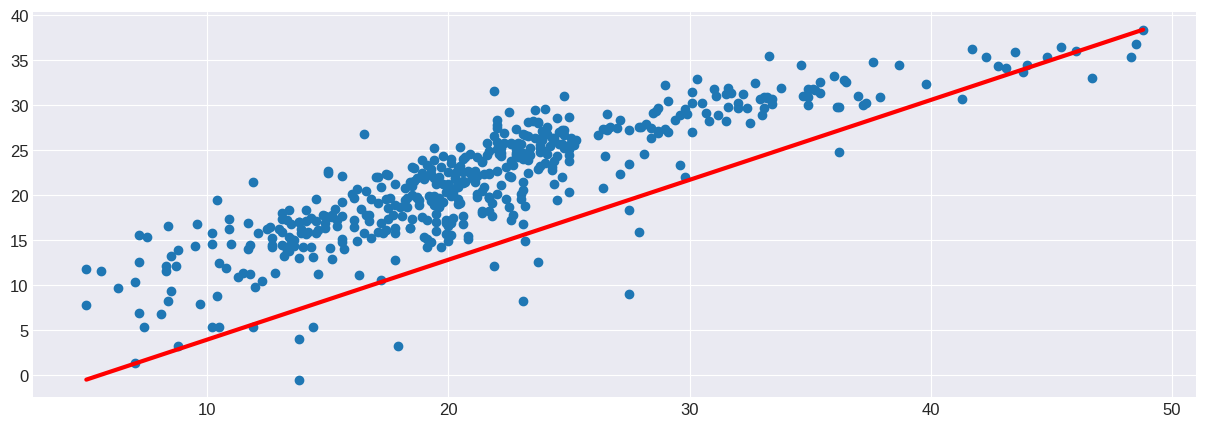

In [23]:
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()],[y_pred.min(), y_pred.max()], c = 'r', lw = 3)

## Logistic Regression

In [26]:
# Data set
from sklearn.datasets import make_moons

X, y = make_moons(N_SAMPLES, 
                  noise=NOISE, 
                  random_state=RANDOM_STATE, 
                  shuffle=True)

X[:, :5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        ...,
        [ 0.2848561 ,  0.79356025],
        [ 1.7125144 , -0.17778646],
        [-0.95877361,  0.53835778]]),
 array([0, 0, 1, 0, 0]))

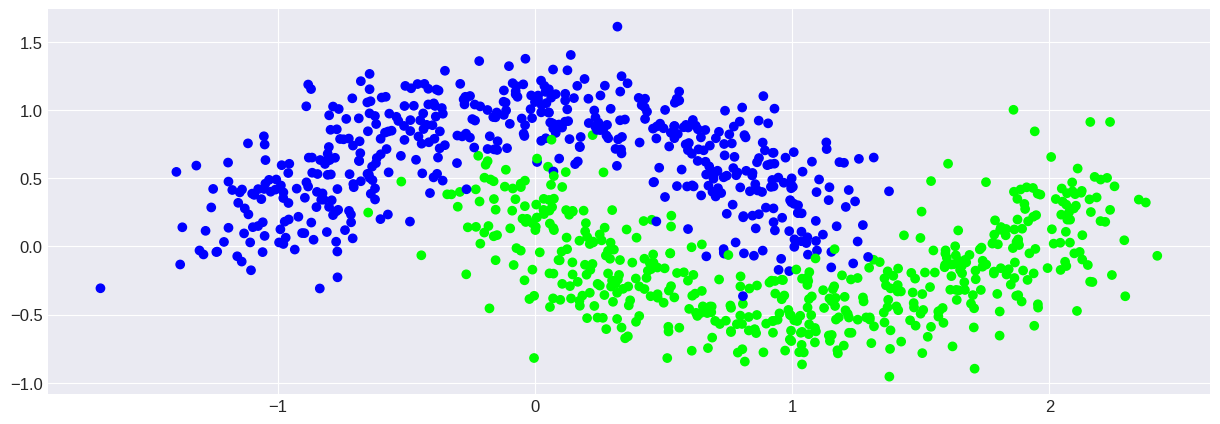

In [27]:
plt.scatter(X[:,0], X[:, 1], c = y, cmap = plt.cm.brg);

In [28]:
clf = LogisticRegression()
clf.fit(X, y)
y_pred = clf.predict(X)

In [29]:
accuracy_score(y, y_pred)

0.869

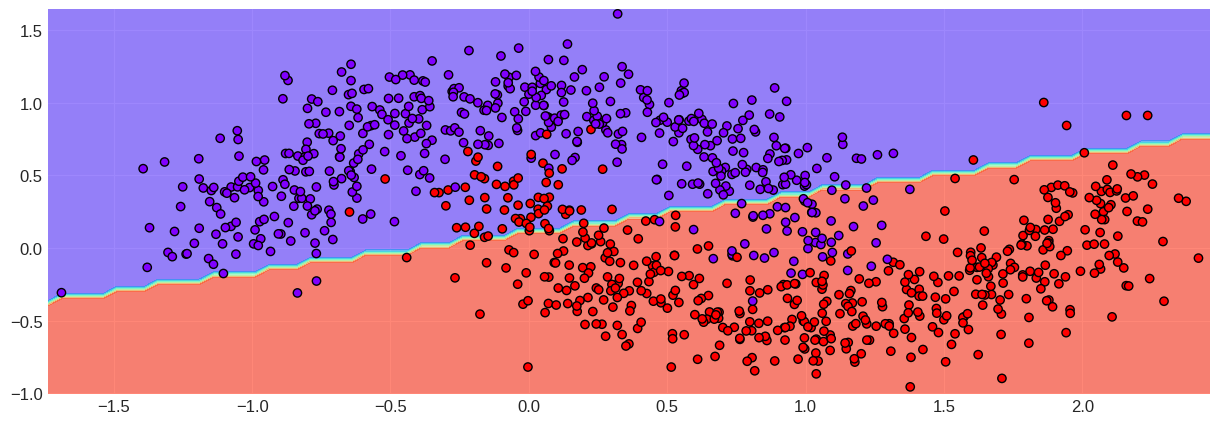

In [30]:
fn_plot_decision_boundary(clf, X, y)